In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.20 GB, difference +0.20 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
import decoupler as dc

In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
home_dir = os.path.expanduser("~")
current_directory = os.getcwd()

adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [6]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [7]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

In [8]:
# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [12]:
#subset adata

select_cell_type = "Basophils"


select_control_sample = "KC"
select_condition_sample = "UL"


select_sample = [
    select_condition_sample,
    select_control_sample
]
sample_mask = adata.obs["sample"].isin(select_sample)



In [13]:
adata = adata[sample_mask].copy()

/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col = "sample_code",
    groups_col = "cell_type_sub_prolif_anno",
    layer = "counts",
    mode = "sum",
    min_cells = 10,
    min_counts = 1000
)
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

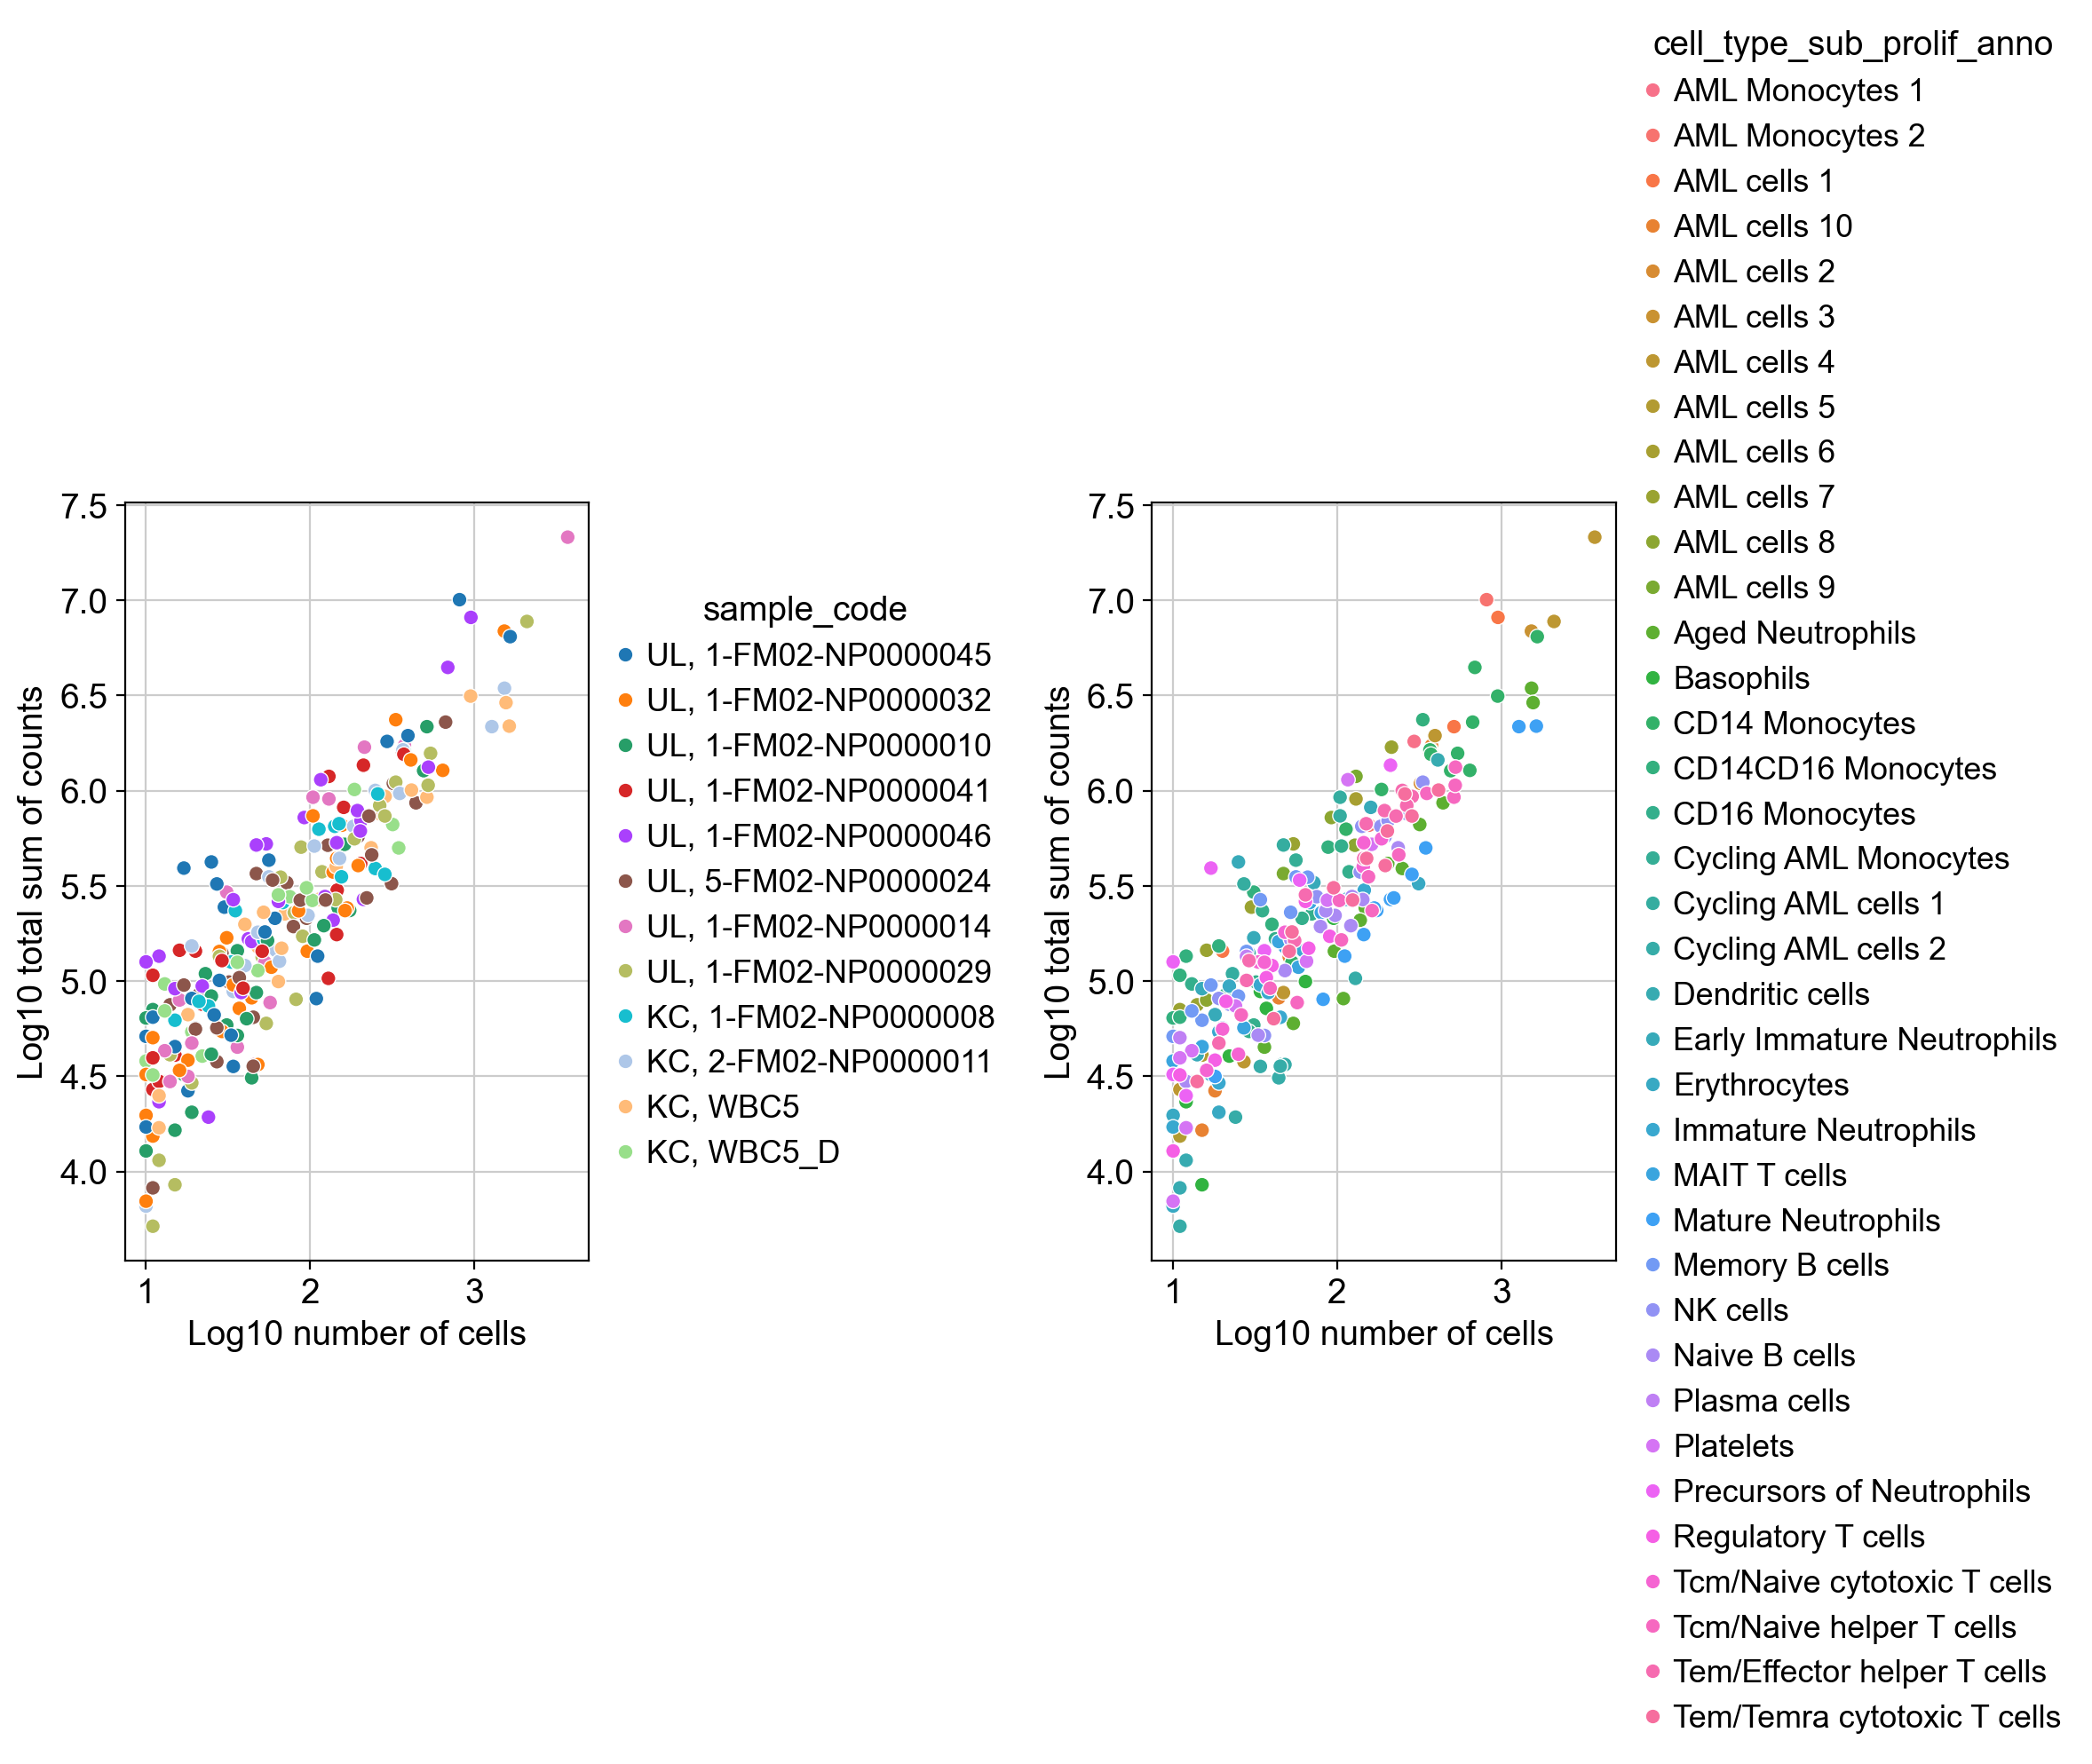

In [17]:
dc.plot_psbulk_samples(pdata, groupby=["sample_code", "cell_type_sub_prolif_anno"], figsize=(12, 9))

In [18]:
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

In [19]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum = 1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value = 10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [20]:
# Select Basophils profiles
print(select_cell_type)
basophils = pdata[pdata.obs["cell_type_sub_prolif_anno"] == select_cell_type].copy()

Basophils


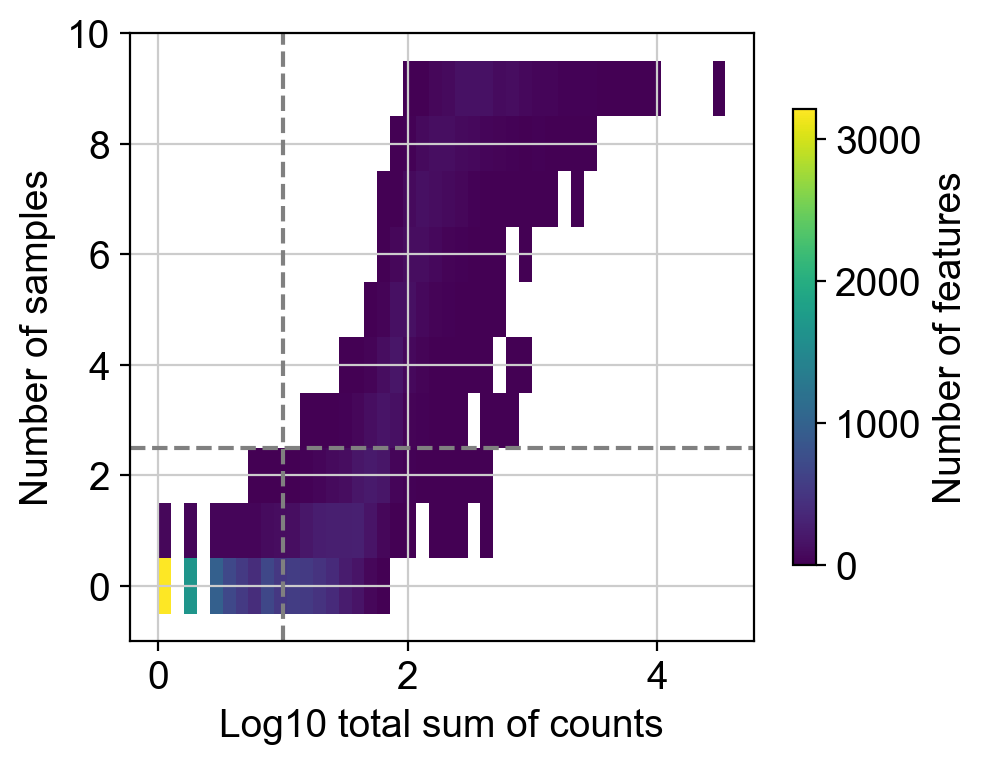

In [21]:
dc.plot_filter_by_expr(basophils, group = "sample", min_count = 5, min_total_count = 10)


In [22]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(basophils, group = "sample", min_count = 5, min_total_count = 10)

# Filter by these genes
basophils = basophils[:, genes].copy()
basophils


AnnData object with n_obs × n_vars = 9 × 4012
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [23]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [24]:
basophils.obs["sample"].unique()

array(['KC', 'UL'], dtype=object)

In [25]:
# Build DESeq2 object
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    adata = basophils,
    design_factors = "sample",
    ref_level = ["sample", select_control_sample],
    refit_cooks = True,
    inference = inference,
)

In [26]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.41 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 0.34 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



In [27]:
# Extract contrast between AML vs HD
stat_res = DeseqStats(
    dds,
    contrast=["sample", select_condition_sample, select_control_sample],
    inference = inference,
)

In [28]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 0.18 seconds.



Log2 fold change & Wald test p-value: sample UL vs KC
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAGAB    3.915716       -1.038005  1.083773 -0.957770  0.338179       NaN
AAK1    35.656233        0.263845  0.392886  0.671557  0.501866  0.843579
AATF     7.344886        0.439848  0.695609  0.632321  0.527177       NaN
ABAT     4.028057       -0.008966  0.827688 -0.010833  0.991357       NaN
ABCA1   10.672490        0.374299  0.718532  0.520921  0.602422  0.895618
...           ...             ...       ...       ...       ...       ...
ZSWIM6  48.693375       -0.439435  0.542981 -0.809300  0.418342  0.827892
ZXDC    11.443706        0.306957  0.564748  0.543529  0.586765  0.891437
ZYX      4.565430       -0.570874  0.753020 -0.758113  0.448383       NaN
ZZEF1   12.198262       -0.448579  0.544992 -0.823092  0.410456  0.827892
ZZZ3     5.515713        0.309033  0.747251  0.413560  0.679197       NaN

[4012 rows x 6 columns]


In [29]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAGAB,3.915716,-1.038005,1.083773,-0.957770,0.338179,NaN
AAK1,35.656233,0.263845,0.392886,0.671557,0.501866,0.843579
AATF,7.344886,0.439848,0.695609,0.632321,0.527177,NaN
ABAT,4.028057,-0.008966,0.827688,-0.010833,0.991357,NaN
ABCA1,10.672490,0.374299,0.718532,0.520921,0.602422,0.895618
...,...,...,...,...,...,...
ZSWIM6,48.693375,-0.439435,0.542981,-0.809300,0.418342,0.827892
ZXDC,11.443706,0.306957,0.564748,0.543529,0.586765,0.891437
ZYX,4.565430,-0.570874,0.753020,-0.758113,0.448383,NaN
ZZEF1,12.198262,-0.448579,0.544992,-0.823092,0.410456,0.827892


In [51]:
# Export volcano genes
results_df.to_csv("dge/pseudobulk_volcano_basophils_AML_vs_HD.csv")

results_df_sorted = results_df.copy()
results_df_sorted[results_df_sorted["padj"] < 0.05].sort_values(by = "log2FoldChange", ascending=False, key=abs).to_excel("dge/pseudobulk_volcano_basophils_AML_vs_HD_filtered_by_padj.xlsx")




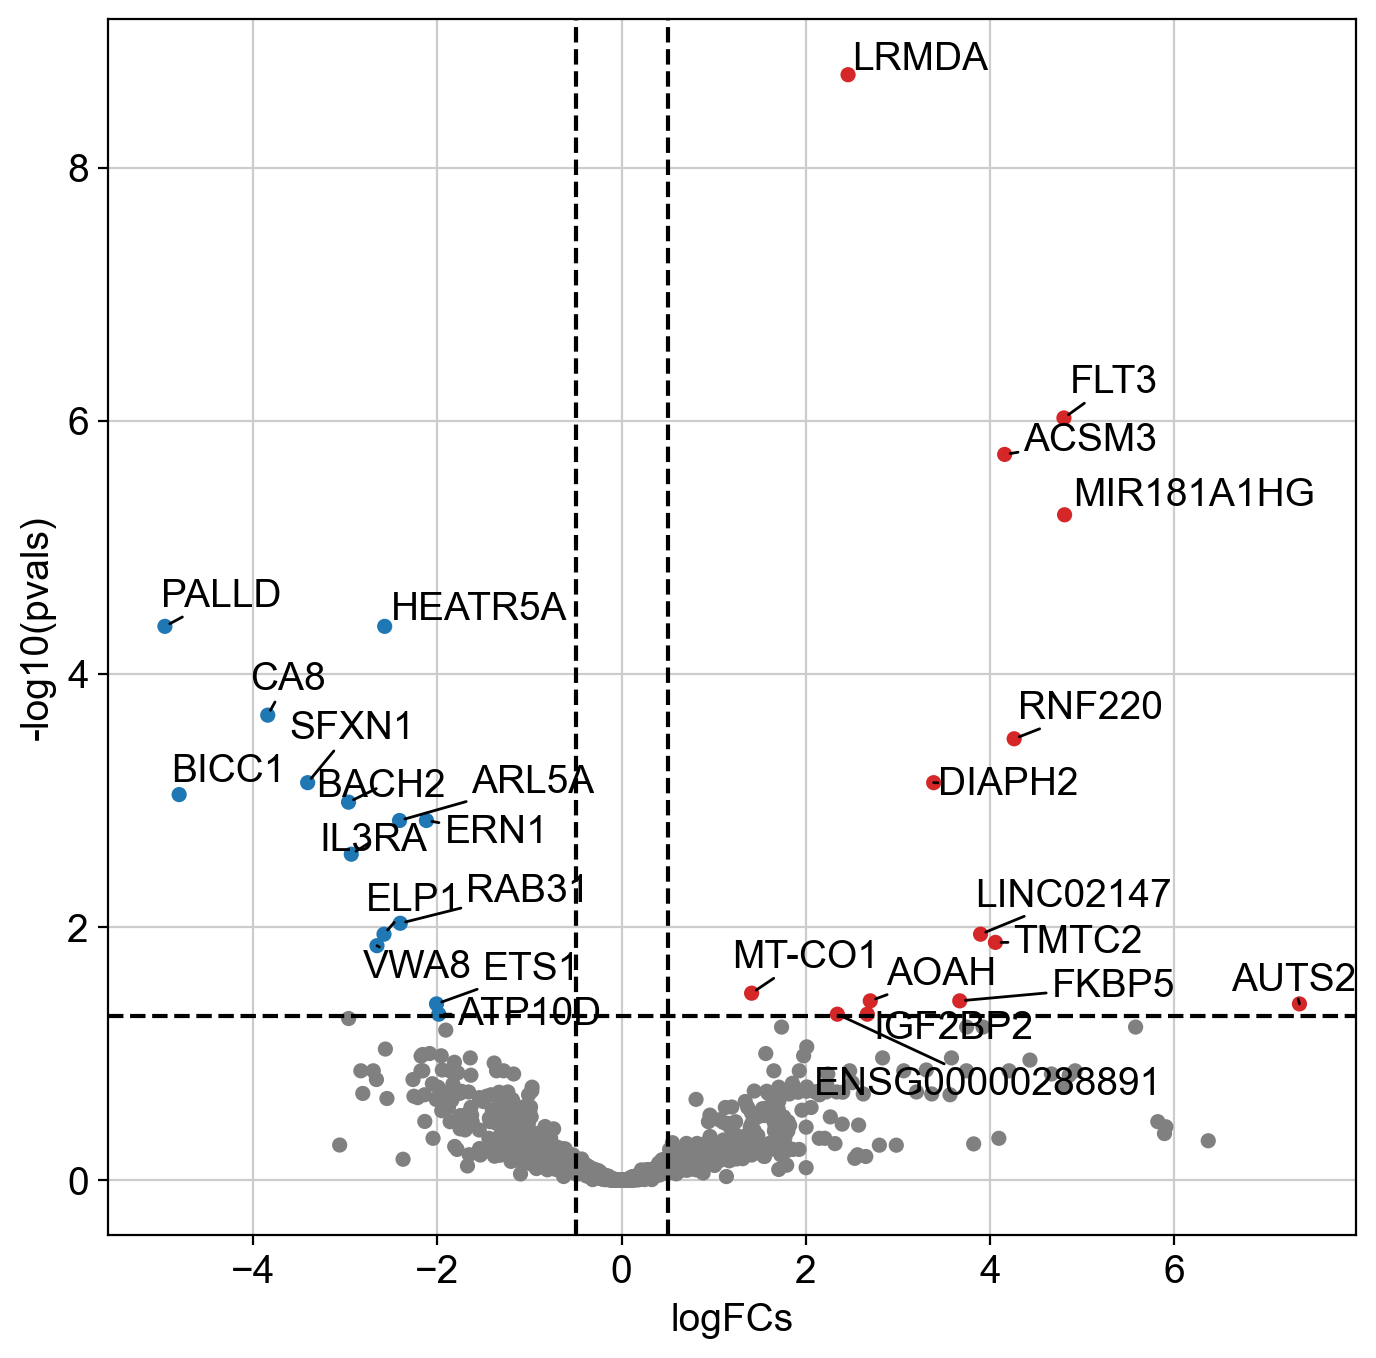

In [52]:
fig = dc.plot_volcano_df(
    results_df,
    x = "log2FoldChange",
    y = "padj",
    top = 50,
    figsize = (8, 8), return_fig = True
)


In [9]:

print(select_cell_type)
mat = results_df[["stat"]].T.rename(index={"stat": select_cell_type})
mat

Basophils


,AAGAB,AAK1,AATF,ABAT,ABCA1,ABCA7,ABCB7,ABCC1,ABCC4,ABCC5,...,ZNRF1,ZNRF2,ZRANB1,ZRANB2,ZRANB2-DT,ZSWIM6,ZXDC,ZYX,ZZEF1,ZZZ3
Basophils,-0.95777,0.671557,0.632321,-0.010833,0.520921,-0.271576,0.16155,-0.038585,2.269376,0.004203,...,0.815144,-0.149061,-0.693642,1.609967,0.680631,-0.8093,0.543529,-0.758113,-0.823092,0.41356


# ORA

In [11]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [13]:
msigdb[msigdb["collection"]=="hallmark"].head()

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT


In [14]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]

# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]

# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]

msigdb_filtered

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


Error ignored: zero-size array to reduction operation minimum which has no identity


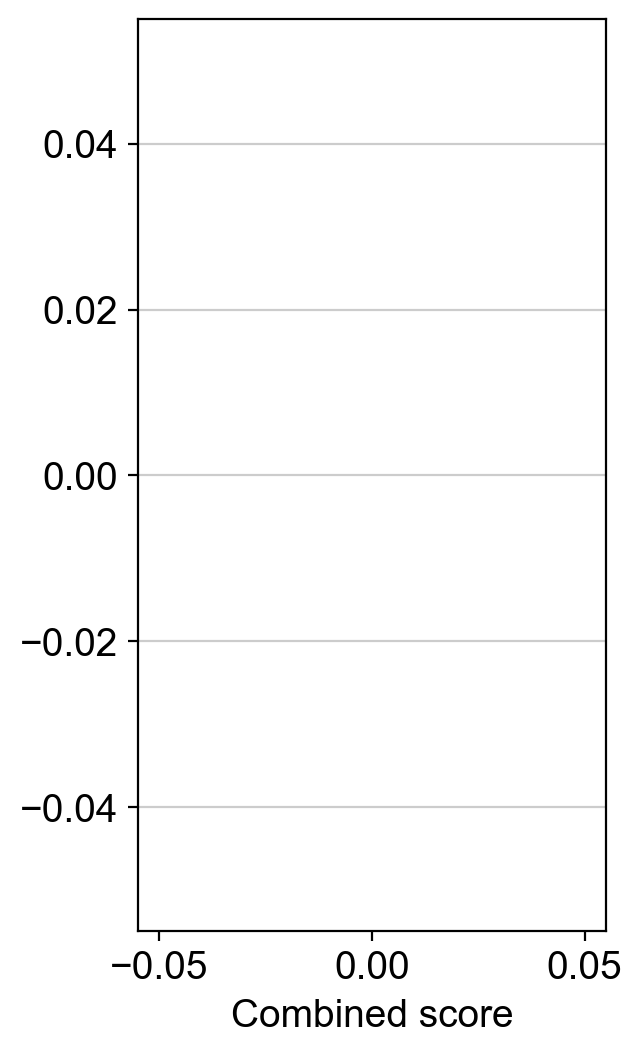

In [37]:
try:
    
    # Infer enrichment with ora using significant deg
    top_genes = results_df[(results_df["padj"] < 0.05)]

    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df = top_genes,
        net = msigdb_filtered,
        source = "geneset",
        target = "genesymbol"
    )
    
    enr_pvals_select = enr_pvals[(enr_pvals["FDR p-value"] < 0.05)].sort_values("Combined score", ascending=False)
    
    dc.plot_dotplot(
        enr_pvals_select,
        x = "Combined score",
        y = "Term",
        s = "Odds ratio", 
        c = "FDR p-value",
        cmap = "viridis",
        scale = 0.4,
        figsize=(3, 6)
    )

except Exception as e:
    print(f"Error ignored: {e}")

# GSEA

In [15]:
gsea_hallmark = dc.get_gsea_df(results_df, stat = "stat", net = msigdb_filtered, source="geneset", target="genesymbol")

In [17]:
gsea_hallmark.to_excel("gsea/gsea_basophils.xlsx")

In [39]:

gsea_hallmark.sort_values(by = "FDR p-value").head(7)

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
43,TNFA_SIGNALING_VIA_NFKB,-0.416102,-1.728627,0.000000,0.000000,76,0.328947,0.166750,MAP3K8;TIPARP;SLC2A3;GPR183;LITAF;TNIP1;EIF1;P...
31,MYC_TARGETS_V1,0.455891,1.856732,0.000000,0.000000,74,0.540541,0.291376,SERBP1;DEK;RPL22;RPL6;NAP1L1;PSMD1;FAM120A;SYN...
22,IL2_STAT5_SIGNALING,-0.468512,-1.877920,0.000000,0.000000,67,0.343284,0.145314,MAP3K8;TNFSF10;SLC2A3;PHTF2;GPR65;SMPDL3A;PRNP...
25,INTERFERON_ALPHA_RESPONSE,-0.425038,-1.512447,0.017751,0.217456,38,0.447368,0.261964,B2M;HLA-C;SP110;STAT2;IFIH1;SAMD9;CASP1;IFITM1...
48,XENOBIOTIC_METABOLISM,-0.404859,-1.413680,0.045276,0.279536,36,0.305556,0.166002,CYFIP2;ATP2A2;PDLIM5;PGD;GSTO1;AQP9;HACL1;PPAR...
1,ALLOGRAFT_REJECTION,-0.322758,-1.318492,0.060241,0.279536,70,0.185714,0.093968,TAPBP;GPR65;B2M;CCR2;HLA-E;JAK2;ETS1;HLA-A;ITG...
44,UNFOLDED_PROTEIN_RESPONSE,-0.387563,-1.390213,0.050657,0.279536,40,0.300000,0.200150,SPCS3;XBP1;ATP6V0D1;SLC30A5;NABP1;HERPUD1;WIPI...


MYC_TARGETS_V1
TNFA_SIGNALING_VIA_NFKB
IL2_STAT5_SIGNALING


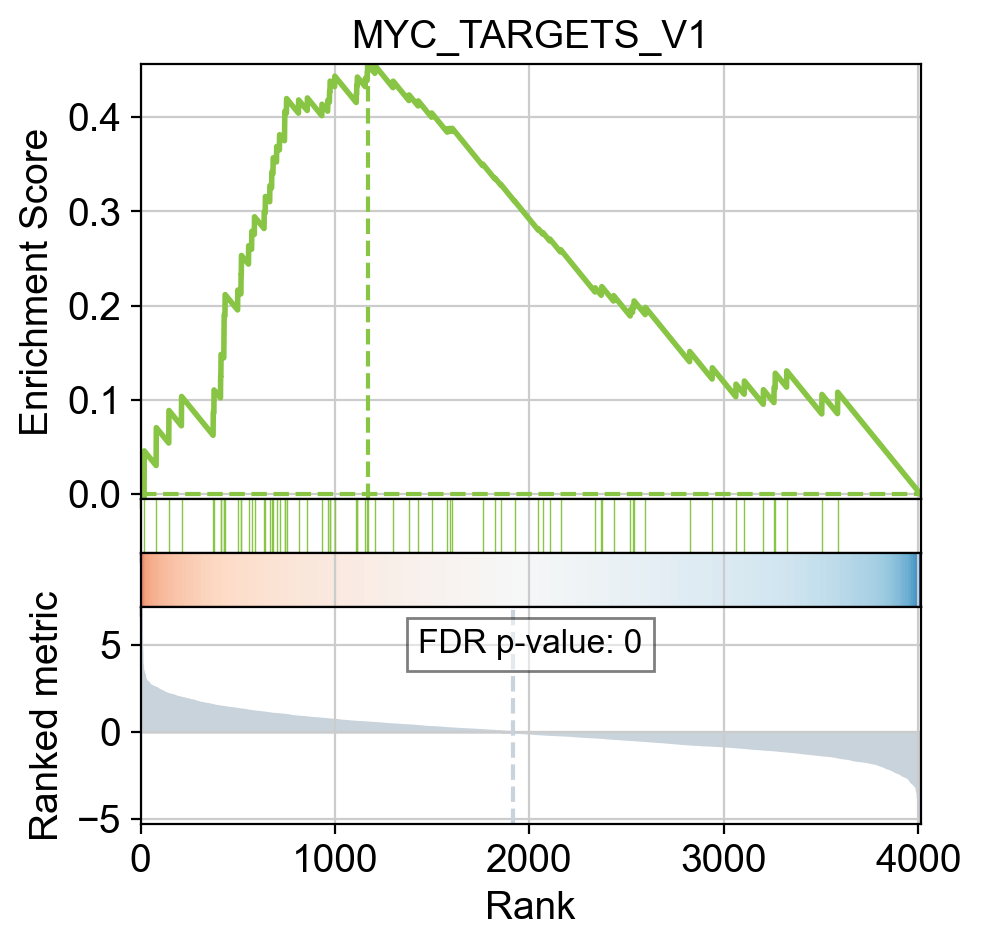

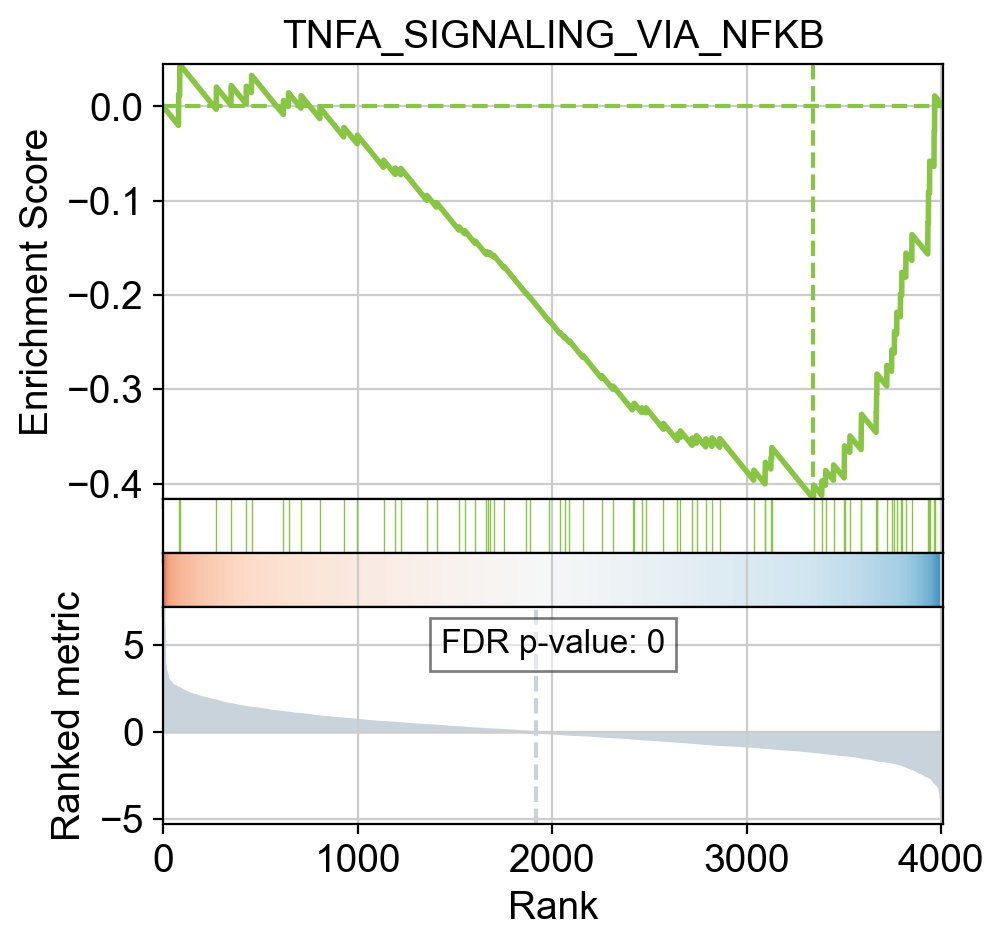

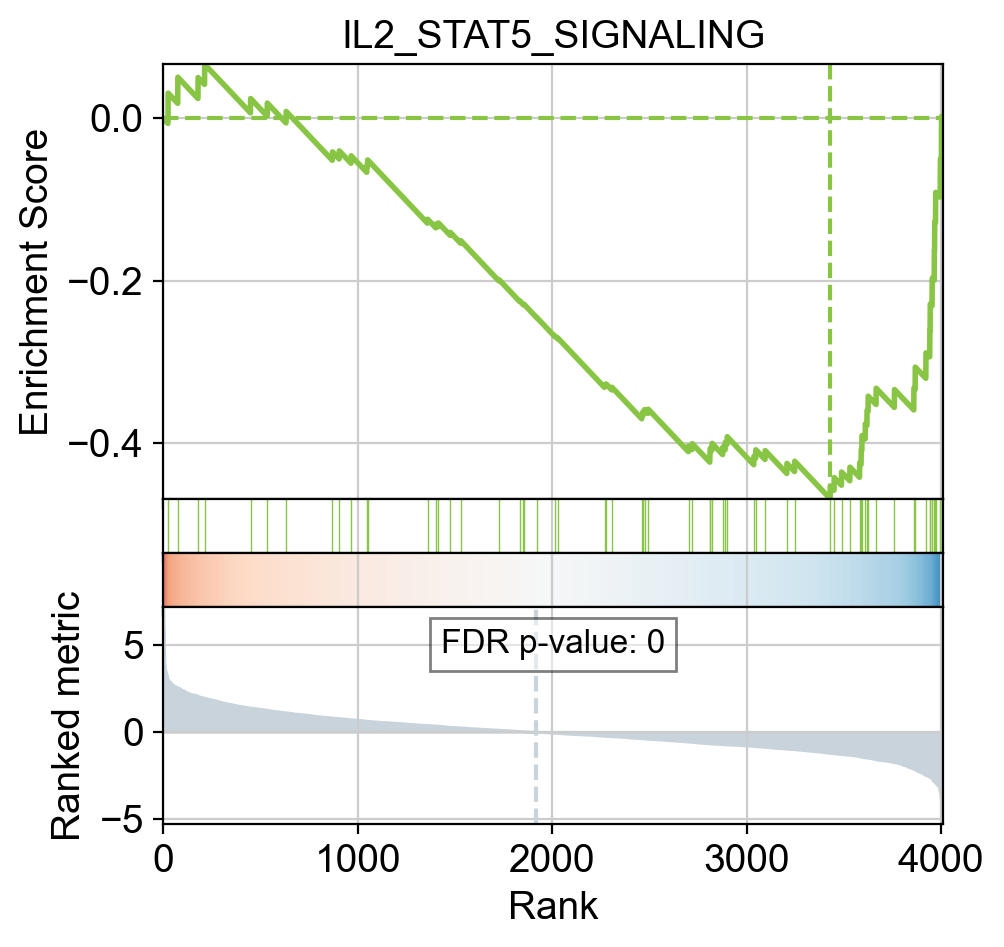

In [72]:
import matplotlib.pyplot as plt

selected_terms = ["MYC_TARGETS_V1", "TNFA_SIGNALING_VIA_NFKB", "IL2_STAT5_SIGNALING"]


for set_name in selected_terms:
    print(set_name)

    # Extract FDR p-value
    fdr_pval = gsea_hallmark.loc[gsea_hallmark['Term'] == set_name, 'FDR p-value'].values
    if len(fdr_pval) > 0:
        fdr_pval_text = f"FDR p-value: {fdr_pval[0]:.3g}"
    else:
        fdr_pval_text = "FDR p-value: N/A"

    # Create the plot
    fig = dc.plot_running_score(
        df=results_df,
        stat='stat',
        net=msigdb_filtered,
        source='geneset',
        target='genesymbol',
        set_name=set_name,
        return_fig = True
    )


    axes = fig[0].get_axes()  
    main_ax = axes[3] 


    xlim = main_ax.get_xlim()
    ylim = main_ax.get_ylim()
    x_center = (xlim[0] + xlim[1]) / 2
    y_center = 5

    main_ax.text(x_center, y_center, fdr_pval_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.savefig(f"figures/final/gsea/pseudobulk_basophils_AML_vs_HD_{set_name}.pdf")


# PROGENy

In [40]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [41]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Basophils,-1.491153,1.298769,-0.593988,0.411509,-1.925346,-0.621194,0.47082,-0.34412,0.610286,-1.449942,-2.221845,-2.227585,0.503011,-1.951814


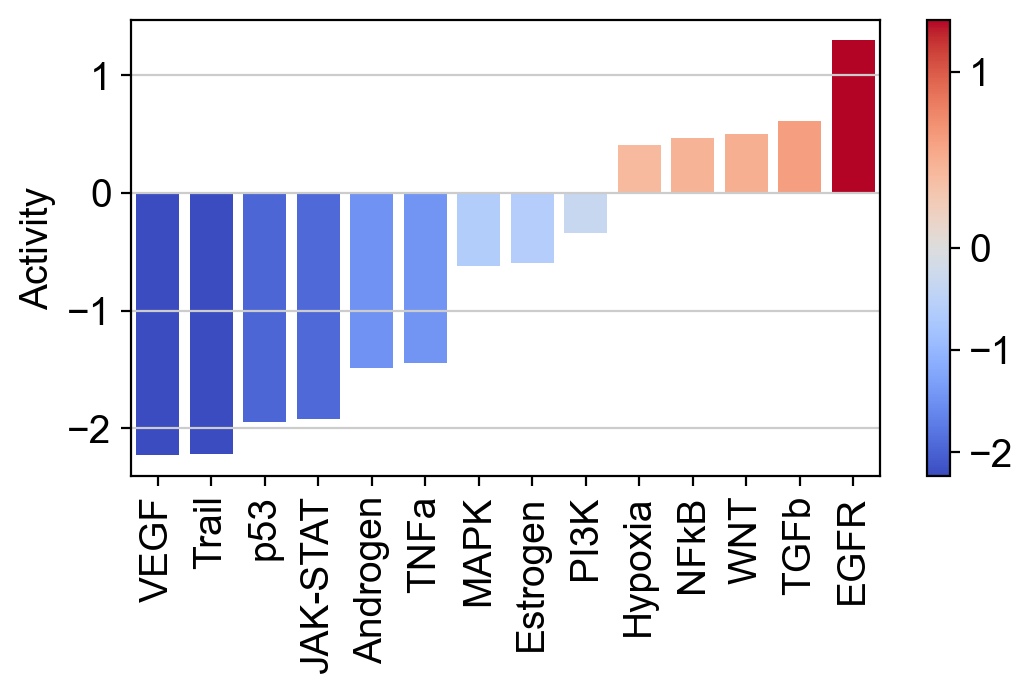

In [42]:
fig = dc.plot_barplot(
    acts=pathway_acts,
    contrast="Basophils",
    top=25,
    vertical=False,
    figsize=(6, 3), return_fig=True
)
# NES - normalized enrichment score
plt.savefig("figures/final/pathway/pathways_activity_score_basophils_AML_vs_HD_v2.pdf", transparent = True, bbox_inches="tight")




# CollecTRI

In [45]:

# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [46]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,ABL1,AHR,AIRE,AP1,AR,ARID4A,ARNT,ASCL1,ATF1,ATF2,...,ZGLP1,ZIC1,ZNF143,ZNF148,ZNF331,ZNF354C,ZNF362,ZNF384,ZNF699,ZNF91
Basophils,-0.506556,-1.249409,-1.15169,-0.944342,1.489521,0.640119,0.054248,0.694316,-2.1461,0.199323,...,-1.154707,0.611758,0.105542,-0.527513,-0.779487,1.848422,1.908501,-1.179288,-0.535074,-2.129915


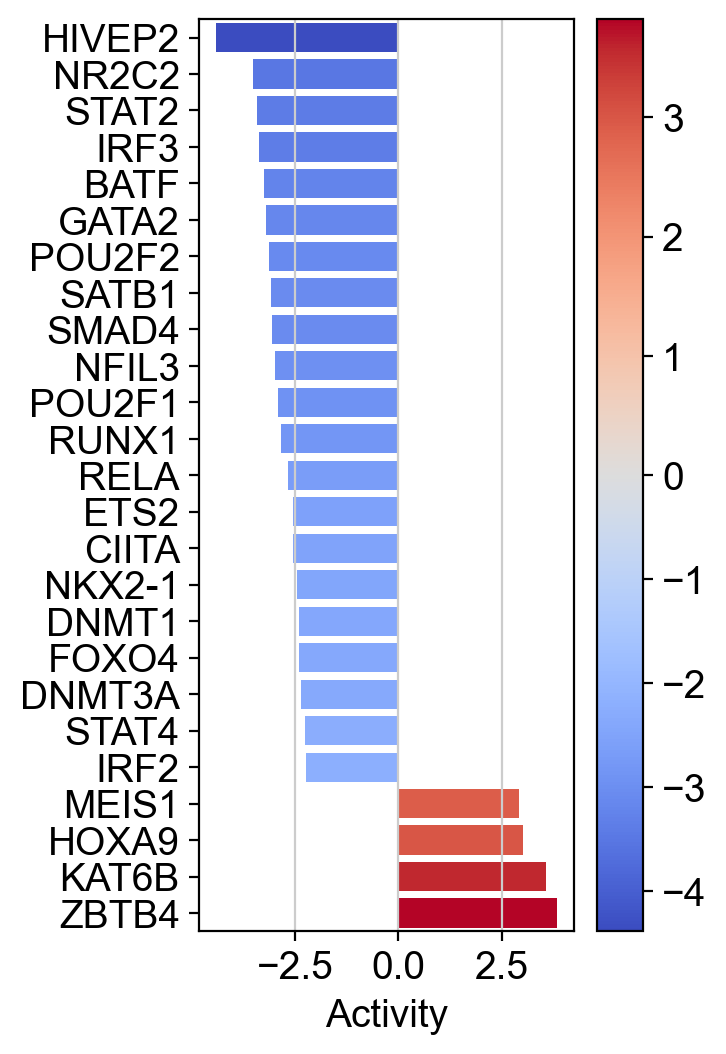

In [47]:
dc.plot_barplot(
    acts=tf_acts,
    contrast="Basophils",
    top=25,
    vertical=True,
    figsize=(3, 6)
)

plt.savefig("figures/final/tf/tf_activity_score_basophils_aml_vs_hd.pdf", transparent = True, bbox_inches="tight")

